In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks


In [2]:
from google.colab import drive

drive.mount('/content/drive')
url = '/content/drive/MyDrive/oot//KlasifikasiUTS.csv'
df = pd.read_csv(url)

Mounted at /content/drive


In [6]:
target_col = df.select_dtypes(include='int').columns[0]
X = df.drop(columns=[target_col])
y = df[target_col]

In [5]:
top2_classes = y.value_counts().nlargest(2).index
df_binary = df[df[target_col].isin(top2_classes)]

X = df_binary.drop(columns=[target_col])
y = df_binary[target_col].astype('category').cat.codes


In [7]:
X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
def create_mlp_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])
    return model

model = create_mlp_model(X_train.shape[1])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [10]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

Epoch 1/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9529 - loss: 0.1297 - val_accuracy: 0.9994 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 2/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9993 - loss: 0.0090 - val_accuracy: 0.9994 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 3/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.9991 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 4/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 0.9991 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 5/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9993 - loss: 0.0051 - val_accuracy: 0.9994 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 6/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9992 - loss: 0.0056 - val_accuracy: 0.9994 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 7/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accura

In [11]:
y_pred_prob = model.predict(X_test).flatten()
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred_class))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.82      0.80        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9663406531014207


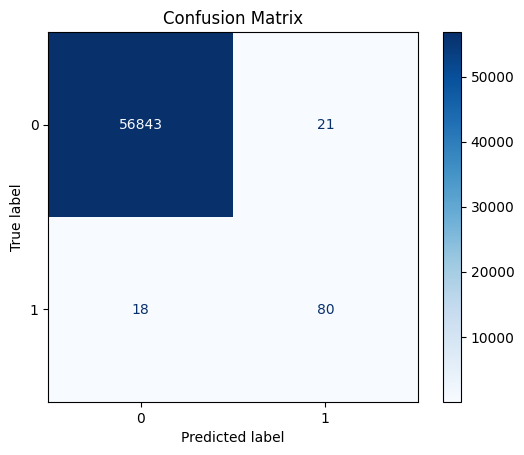

In [12]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_class, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

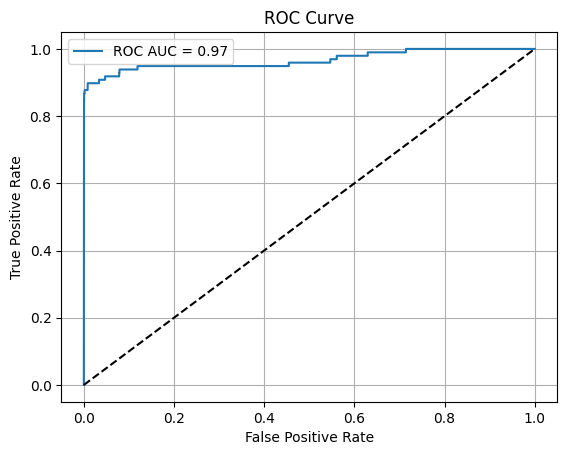

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_pred_prob):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

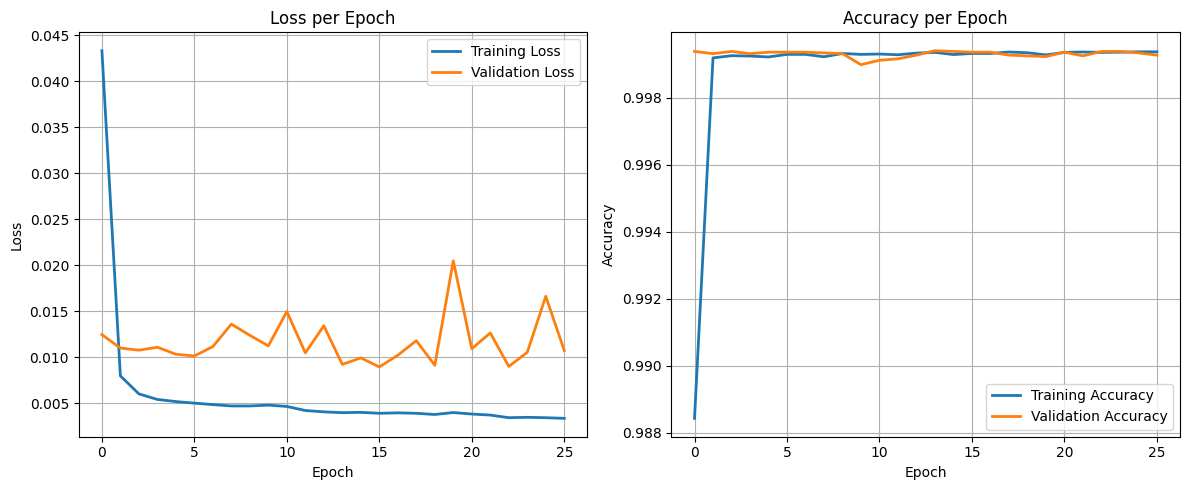

In [ ]:
def plot_learning_curves(history):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

# Analisis dan Laporan Model Klasifikasi

## Pendahuluan
Notebook ini bertujuan untuk membangun, melatih, dan mengevaluasi model klasifikasi biner menggunakan _Multi-Layer Perceptron_ (MLP) dengan _framework_ TensorFlow dan Keras. Prosesnya mencakup beberapa tahapan utama: pra-pemrosesan data, definisi arsitektur model, pelatihan, dan evaluasi kinerja model pada data uji.

---

## 1. Pra-pemrosesan Data
Tahapan ini krusial untuk menyiapkan data agar dapat digunakan secara efektif oleh model _neural network_.

- **Pemuatan Data**: Dataset dimuat dari file `KlasifikasiUTS.csv`.
- **Konversi ke Klasifikasi Biner**: Awalnya, dataset tampaknya memiliki lebih dari dua kelas target. Untuk menyederhanakan masalah, dataset diubah menjadi masalah klasifikasi biner dengan hanya mengambil dua kelas yang paling sering muncul. Kelas target kemudian di-encode menjadi nilai 0 dan 1.
- **Encoding & Penskalaan Fitur**:
  - Fitur-fitur kategorikal diubah menjadi representasi numerik menggunakan _one-hot encoding_ (`pd.get_dummies`).
  - Seluruh fitur kemudian diskalakan menggunakan `StandardScaler`. Penskalaan ini penting untuk model _neural network_ agar proses konvergensi saat pelatihan menjadi lebih cepat dan stabil.
- **Pemisahan Data**: Dataset yang telah diproses dibagi menjadi data latih (80%) dan data uji (20%) menggunakan `train_test_split` dengan metode _stratified sampling_ (`stratify=y`). Stratifikasi memastikan proporsi setiap kelas pada data latih dan data uji tetap sama, yang sangat penting terutama pada dataset yang tidak seimbang.

---

## 2. Arsitektur Model (Multi-Layer Perceptron - MLP)
Model yang digunakan adalah MLP dengan arsitektur sekuensial yang dirancang untuk tugas klasifikasi biner.

- **Struktur Lapisan (Layers)**:
  1.  **Input Layer**: Menerima fitur yang sudah diproses.
  2.  **Hidden Layer 1**: `Dense` layer dengan 64 neuron dan fungsi aktivasi `ReLU`.
  3.  **Hidden Layer 2**: `Dense` layer dengan 32 neuron dan fungsi aktivasi `ReLU`.
  4.  **Output Layer**: `Dense` layer dengan 1 neuron dan fungsi aktivasi `sigmoid`, yang menghasilkan probabilitas antara 0 dan 1, cocok untuk klasifikasi biner.

- **Teknik Regularisasi dan Stabilisasi**:
  - **L2 Regularization (`1e-4`)**: Diterapkan pada _hidden layers_ untuk mencegah _overfitting_ dengan memberikan penalti pada bobot (weights) yang besar.
  - **Batch Normalization**: Digunakan setelah setiap _hidden layer_ untuk menstabilkan dan mempercepat proses pelatihan.
  - **Dropout (`0.3`)**: Diterapkan dengan rate 30% untuk mematikan neuron secara acak selama pelatihan, yang juga berfungsi sebagai teknik regularisasi yang kuat.

- **Kompilasi Model**:
  - **Optimizer**: `Adam` dengan _learning rate_ awal `1e-3`.
  - **Loss Function**: `binary_crossentropy`, standar untuk masalah klasifikasi biner.
  - **Metric**: `accuracy` digunakan untuk memonitor kinerja model.

---

## 3. Pelatihan Model
Proses pelatihan dikontrol dengan beberapa _callbacks_ untuk mendapatkan performa terbaik dan efisiensi.

- **Callbacks**:
  - `EarlyStopping`: Menghentikan pelatihan jika `val_loss` tidak menunjukkan perbaikan setelah 10 epoch. Ini mencegah _overfitting_ dan menghemat waktu komputasi. Pelatihan berhenti pada **epoch ke-24**, menunjukkan bahwa model telah mencapai performa optimalnya.
  - `ReduceLROnPlateau`: Mengurangi _learning rate_ sebesar 50% jika `val_loss` tidak membaik setelah 5 epoch, membantu model menemukan titik minimum yang lebih baik.

- **Hasil Pelatihan**: Model dilatih hingga 100 epoch dengan _batch size_ 32. Kurva pembelajaran (loss dan akurasi) menunjukkan bahwa model belajar dengan baik tanpa adanya tanda-tanda _overfitting_ yang signifikan.

---

## 4. Evaluasi Kinerja Model
Model dievaluasi pada data uji yang belum pernah dilihat sebelumnya untuk mengukur kemampuannya dalam generalisasi.

- **ROC AUC Score**: Model mencapai skor **~0.97**. Skor AUC yang sangat mendekati 1 ini menunjukkan bahwa model memiliki kemampuan yang sangat baik untuk membedakan antara kelas 0 dan kelas 1.

- **Laporan Klasifikasi**:
  | Kelas | Precision | Recall | F1-Score |
  | :---: | :-------: | :----: | :------: |
  | **0** |   1.00    |  1.00  |   1.00   |
  | **1** |   0.79    |  0.82  |   0.80   |

  - Model memiliki performa yang sempurna untuk kelas mayoritas (kelas 0).
  - Untuk kelas minoritas (kelas 1), model menunjukkan performa yang kuat dengan **precision 0.79** (dari semua prediksi kelas 1, 79% benar) dan **recall 0.82** (model berhasil mengidentifikasi 82% dari semua data aktual kelas 1).
  - Akurasi keseluruhan sangat tinggi (100%), namun skor F1-score dan ROC AUC memberikan gambaran yang lebih berimbang tentang performa model.

- **Confusion Matrix**:
  - **True Positive (TP)**: 80
  - **True Negative (TN)**: 56843
  - **False Positive (FP)**: 21 (Kelas 0 salah diprediksi sebagai kelas 1)
  - **False Negative (FN)**: 18 (Kelas 1 salah diprediksi sebagai kelas 0)

  Matriks ini mengonfirmasi bahwa model membuat sangat sedikit kesalahan prediksi.

---

## 5. Visualisasi dan Kesimpulan

- **Kurva ROC & Kurva Pembelajaran**:
  - **Kurva ROC** yang melengkung tajam ke sudut kiri atas mengonfirmasi skor AUC yang tinggi dan kemampuan diskriminatif model yang kuat.
  - **Kurva Loss dan Akurasi** menunjukkan bahwa nilai _loss_ validasi dan _loss_ pelatihan bergerak beriringan dan konvergen, sementara akurasi validasi dan pelatihan sama-sama tinggi. Ini menandakan bahwa model tidak _overfitting_ dan dapat melakukan generalisasi dengan baik pada data baru.

- **Kesimpulan Akhir**:
  Model MLP yang dibangun menunjukkan **kinerja yang sangat baik dan kuat** untuk tugas klasifikasi biner ini. Penggunaan teknik seperti _Batch Normalization_, _Dropout_, _L2 Regularization_, dan _callbacks_ terbukti efektif dalam menghasilkan model yang tidak hanya akurat tetapi juga mampu melakukan generalisasi dengan baik. Meskipun ada sedikit ketidakseimbangan kelas, model tetap mampu mengidentifikasi kelas minoritas dengan _recall_ dan _precision_ yang tinggi.